In [3]:
### Load libraries
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

### Create Equations
Based on the Excel Spreadsheet:


In [7]:
# Equations field-based approach
def equations(no_pairs, no_transects, approach,
              acquisition_change=1, analys_change=1, miscel_change=1):
    
    # Equations Field-based approach
    if approach=='Field':
        acquistion_cost = (18.33333*no_transects)*no_pairs + (366.6666666666667*no_transects)*no_pairs
        analysis_cost =  (34.375*no_transects)*no_pairs
        analysis_cost_fixed = 1320
        miscel_cost = (176.20833333333334*no_transects)*no_pairs
        

    # Equations RPAS-based approach - BASIC
    elif approach=='RPAS - Basic':
        acquistion_cost = (36.666666666666664*no_transects)*no_pairs + (575*no_transects)*no_pairs 
        analysis_cost = (110*no_transects)*no_pairs
        analysis_cost_fixed = 7590
        miscel_cost = (251.1916666666667*no_transects)*no_pairs
        


    # Equations RPAS-based approach - ADVANCED
    elif approach=='RPAS - Advanced':
        acquistion_cost = (39.166666666666664*no_transects)*no_pairs + (450*no_transects)*no_pairs 
        analysis_cost = (110*no_transects)*no_pairs 
        analysis_cost_fixed = 7590
        miscel_cost = (236.66666666666666*no_transects)*no_pairs
        

    changes_string = str(acquisition_change) + '_' + str(analys_change) + '_' + str(miscel_change)
    return(acquistion_cost * acquisition_change, 
           analysis_cost * analys_change, 
           analysis_cost_fixed * analys_change, 
           miscel_cost * miscel_change, 
           changes_string)


### Calculate Cost Values for Various Numbers of Site Pairs and Approaches
* Includes values for sensitivity analysis.
* Includes RPAS (two RPAS set-ups) and field-based (four different sample sizes) approaches

In [8]:
df = pd.DataFrame(columns=['no_pairs','no_transects','approach',
                           'Data acquisition', 'Analysis', 'Analysis_fixed', 'Miscellaneous', 'changes'])

row = 0
for appr in ['Field', 'RPAS - Basic', 'RPAS - Advanced']:
    for pairs in range(1,101):
        for change in [0.9, 1.0, 1.1]:
            if appr=='Field':
                for trans in [12,16,20,24]:
                    outputs_1 = equations(pairs, trans, appr, acquisition_change=change, analys_change=1, miscel_change=1)
                    outputs_2 = equations(pairs, trans, appr, acquisition_change=1, analys_change=change, miscel_change=1)
                    outputs_3 = equations(pairs, trans, appr, acquisition_change=1, analys_change=1, miscel_change=change)
                    df.loc[row] = [pairs] + [trans] + [appr+' - '+str(trans)] + [outputs_1[0]] + [outputs_1[1]] + [outputs_1[2]] + [outputs_1[3]] + [outputs_1[4]]
                    row += 1
                    df.loc[row] = [pairs] + [trans] + [appr+' - '+str(trans)] + [outputs_2[0]] + [outputs_2[1]] + [outputs_2[2]] + [outputs_2[3]] + [outputs_2[4]]
                    row += 1
                    df.loc[row] = [pairs] + [trans] + [appr+' - '+str(trans)] + [outputs_3[0]] + [outputs_3[1]] + [outputs_3[2]] + [outputs_3[3]] + [outputs_3[4]]
                    row += 1
            else:
                trans = 12
                outputs_1 = equations(pairs, trans, appr, acquisition_change=change, analys_change=1, miscel_change=1)
                outputs_2 = equations(pairs, trans, appr, acquisition_change=1, analys_change=change, miscel_change=1)
                outputs_3 = equations(pairs, trans, appr, acquisition_change=1, analys_change=1, miscel_change=change)
                df.loc[row] = [pairs] + [trans] + [appr] + [outputs_1[0]] + [outputs_1[1]] + [outputs_1[2]] + [outputs_1[3]] + [outputs_1[4]]
                row += 1
                df.loc[row] = [pairs] + [trans] + [appr] + [outputs_2[0]] + [outputs_2[1]] + [outputs_2[2]] + [outputs_2[3]] + [outputs_2[4]]
                row += 1
                df.loc[row] = [pairs] + [trans] + [appr] + [outputs_3[0]] + [outputs_3[1]] + [outputs_3[2]] + [outputs_3[3]] + [outputs_3[4]]
                row += 1

df['hectares'] = df['no_pairs'] * 40

df['Data acquisition'] = df['Data acquisition'] / df['hectares']
df['Analysis'] = df['Analysis'] / df['hectares']
df['Analysis_fixed'] = df['Analysis_fixed'] / df['hectares']
df['Miscellaneous'] = df['Miscellaneous'] / df['hectares']

df['cost_by_ha'] = df['Data acquisition'] + df['Analysis'] + df['Analysis_fixed'] + df['Miscellaneous']

df.drop_duplicates(inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,no_pairs,no_transects,approach,Data acquisition,Analysis,Analysis_fixed,Miscellaneous,changes,hectares,cost_by_ha
0,1,12,Field - 12,103.949999,10.31250,33.0,52.862500,0.9_1_1,40,200.124999
1,1,12,Field - 12,115.499999,9.28125,29.7,52.862500,1_0.9_1,40,207.343749
2,1,12,Field - 12,115.499999,10.31250,33.0,47.576250,1_1_0.9,40,206.388749
3,1,16,Field - 16,138.599999,13.75000,33.0,70.483333,0.9_1_1,40,255.833332
4,1,16,Field - 16,153.999999,12.37500,29.7,70.483333,1_0.9_1,40,266.558332


### Plot 1: Break-even Points of Various Approaches

In [9]:
def get_intersects(df, column_x, column_y1, column_y2):
    import numpy as np 
    from scipy.interpolate import interp1d

    # Sample data points for two curves
    x = df[column_x].to_numpy()
    y1 = df[column_y1].to_numpy()
    y2 = df[column_y2].to_numpy()

    # Create interpolation functions for the curves
    interp_func1 = interp1d(x, y1, kind='linear')
    interp_func2 = interp1d(x, y2, kind='linear')

    # Create new data points
    x_dense = [i for i in np.arange(x.min(), x.max(), 0.01)]
    y1_dense = interp_func1(x_dense)
    y2_dense = interp_func2(x_dense)

    # Data points to list with xy coordinates
    xy_points1 = [(x_dense[i], y1_dense[i]) for i in range(len(x_dense))]
    xy_points2 = [(x_dense[i], y2_dense[i]) for i in range(len(x_dense))]

    # Loop-up closest points
    intersects = []
    for i in range(len(xy_points1)):
        p1 = xy_points1[i]
        p2 = xy_points2[i]
        
        if abs(p2[1]-p1[1]) <= 1:
            intersects.append((p1[0],p1[1]))
        
    # Check if list is empty 
    if not intersects:
        intersects = None # When there are no intersect points
    else:
        intersects = intersects[0] # just pick one of the points    
        
    return(intersects)

In [10]:
### Find intersections for curved lines

# Pivot table
piv_df = df.pivot(index=['no_pairs','changes'], columns='approach', values='cost_by_ha').reset_index()

# Run function to get intersect points
intersects = []
for change in piv_df['changes'].unique():
    piv_df_copy = piv_df.loc[piv_df['changes']==change]
    for i in [i for i in piv_df.columns if 'RPAS' in i]:
        for j in [i for i in piv_df.columns if 'Field' in i]:
            intersects.append((i, j, change, get_intersects(piv_df_copy, 'no_pairs', i, j)))

# List do DataFrame
intersects = pd.DataFrame(intersects, columns=['RPAS', 'Field', 'Change', 'Break-even point'])

# Remove rows with "None" values from DataFrame
intersects = intersects.loc[~intersects['Break-even point'].isna()]

# Splitting the values in the 'Break-even point' column into 'x' and 'y'
intersects[['x', 'y']] = intersects['Break-even point'].apply(lambda x: pd.Series(str(x).strip('()').split(', ')))

# Convert the new columns to numeric values
intersects[['x', 'y']] = intersects[['x', 'y']].apply(pd.to_numeric)

# Add change category
# Iterate over each row in the 'intersects' DataFrame
for index, row in intersects.iterrows():

    changes = row['Change'].split('_')

    change_cat = None

    # Check for conditions and assign the appropriate change_cat value
    if (changes[0] != '1') and (changes[0] != '1.0'):
        change_cat = 'Data acquisition'
        change = changes[0]
    elif (changes[1] != '1') and (changes[1] != '1.0'):   
        change_cat = 'Analysis'
        change =  changes[1]
    elif (changes[2] != '1') and (changes[2] != '1.0'):
        change_cat = 'Miscellaneous'
        change = changes[2]

    # Assign the change_cat value to a new column in the 'intersects' DataFrame
    intersects.at[index, 'change_cat'] = change_cat

# Check
intersects.head()

,RPAS,Field,Change,Break-even point,x,y,change_cat
2,RPAS - Advanced,Field - 20,0.9_1_1,"(3.6800000000000024, 288.57249999999993)",3.68,288.572500,Data acquisition
3,RPAS - Advanced,Field - 24,0.9_1_1,"(1.7400000000000007, 355.61749999999995)",1.74,355.617500,Data acquisition
6,RPAS - Basic,Field - 20,0.9_1_1,"(25.98000000000002, 280.81141538461543)",25.98,280.811415,Data acquisition
7,RPAS - Basic,Field - 24,0.9_1_1,"(2.6400000000000015, 348.1424999999999)",2.64,348.142500,Data acquisition
10,RPAS - Advanced,Field - 20,1.0_1_1,"(3.330000000000002, 308.78187499999996)",3.33,308.781875,None


### Plot 2: Sensitivity Analysis - Break-even Points of Various Approaches

In [11]:
# Prepare data for sensitivity plotting
intersects_mean = intersects.loc[intersects['Change']=='1.0_1_1'] # Keep mean values (i.e., no change)
intersects_shift = intersects.loc[intersects['Change']!='1.0_1_1'] # Keep changed values (i.e., +- 10%)

# Left Join
intersects_shift = pd.merge(left=intersects_shift, right=intersects_mean, on=['RPAS', 'Field'], how='left', suffixes=('','_mean'))

# Calculate percentual change for x (no. site pairs) and y (cost / ha)
intersects_shift['x_change_%'] = ((intersects_shift['x']-intersects_shift['x_mean'])/intersects_shift['x_mean'])*100
intersects_shift['y_change_%'] = ((intersects_shift['y']-intersects_shift['y_mean'])/intersects_shift['y_mean'])*100

# Rounding values
for i in ['x_change_%', 'y_change_%', 'x', 'y', 'x_mean', 'y_mean']:
    intersects_shift[i] = intersects_shift[i].round(decimals=1)

intersects_shift = intersects_shift.loc[(~intersects_shift['change_cat'].isna())]

intersects_shift['Change'] = np.where(intersects_shift['Change'].str.contains('0.9'), 
                                      '-10% Change', intersects_shift['Change'])
intersects_shift['Change'] = np.where(intersects_shift['Change'].str.contains('1.1'), 
                                      '+10% Change', intersects_shift['Change'])

intersects_shift['Scenario'] = intersects_shift['RPAS'] + '_' + intersects_shift['Field']
intersects_shift['Scenario'] = intersects_shift['Scenario'].replace({'RPAS - Advanced_Field - 20':'Intensive drone vs.\nfield scenario', 
                          'RPAS - Advanced_Field - 24':'Intensive drone vs.\nIntensive field scenario', 
                          'RPAS - Basic_Field - 20':'Drone vs.\nField scenario', 
                          'RPAS - Basic_Field - 24':'Drone vs.\nIntensive field scenario'})
intersects_shift = intersects_shift.pivot(index=['Scenario', 'change_cat'],columns='Change',values='x_change_%').reset_index()

# Sort
intersects_shift['Scenario'] = pd.Categorical(intersects_shift['Scenario'], 
                                              ['Drone vs.\nField scenario', 'Drone vs.\nIntensive field scenario',
                                               'Intensive drone vs.\nfield scenario', 'Intensive drone vs.\nIntensive field scenario'])
intersects_shift = intersects_shift.sort_values(by='Scenario')

C:\Users\rnuijten.stu\AppData\Local\Temp\ipykernel_20816\1561734864.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  slct_df['change_cat'] = slct_df['change_cat'].replace({'Analysis':'Analysis (total)'})


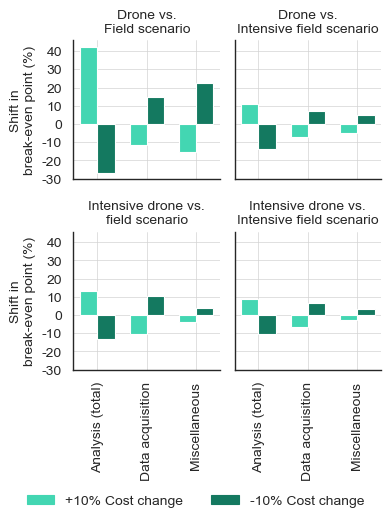

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches

font_size = 10

# create map axis object
sns.set_style('white')
sns.set_context("paper", font_scale = 1)
axs_pos = [(0,0),(0,1),(1,0),(1,1)]

fig, axs = plt.subplots(2, 2, figsize=(4,5), sharex=True, sharey=True)

for i in range(len(intersects_shift['Scenario'].unique())):
    ax = axs[axs_pos[i][0], axs_pos[i][1]]
    scenarios = intersects_shift['Scenario'].unique()[i]

    # Select data
    slct_df = intersects_shift.loc[intersects_shift['Scenario']==scenarios]
    slct_df['change_cat'] = slct_df['change_cat'].replace({'Analysis':'Analysis (total)'})
    cost_factors = slct_df['change_cat']
    plus_10_changes = slct_df['+10% Change']  # Percentage shifts for +10% change
    minus_10_changes = slct_df['-10% Change']  # Percentage shifts for -10% change

    x = np.arange(len(cost_factors))  # the label locations
    width = 0.35  # the width of the bars

    rects1 = ax.bar(x - width/2, plus_10_changes, width, label='+10% Change', color='#43d6b2')
    rects2 = ax.bar(x + width/2, minus_10_changes, width, label='-10% Change', color='#147960')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_title(scenarios, fontdict={'fontsize': font_size})
    ax.set_xticks(x,)
    ax.set_xticklabels(cost_factors, fontdict={'fontsize': font_size},rotation=90)
    ax.set_yticks([-30,-20,-10,0,10,20,30,40],)
    ax.set_yticklabels([-30,-20,-10,0,10,20,30,40], fontdict={'fontsize': font_size})


    ax.grid(True, which='both', axis='both', color='lightgray', linestyle='-', linewidth=0.5)

axs[0,0].set_ylabel("Shift in\nbreak-even point (%)", fontdict={'fontsize': font_size})
axs[1,0].set_ylabel("Shift in\nbreak-even point (%)", fontdict={'fontsize': font_size})

sns.despine()
fig.tight_layout()

# Create custom legend handles
light_g_square = mpatches.Patch(color='#43d6b2', label='+10% Cost change')
dark_g_square = mpatches.Patch(color='#147960', label='-10% Cost change')

# Add the custom legend below the plots
plt.figlegend(handles=[light_g_square, dark_g_square],
              loc='lower center', ncol=2, labelspacing=0.2, prop={'size':font_size}, 
              bbox_to_anchor=(0.5, -0.05), frameon=False)

# fig.savefig("Figures\Sensitivity_analysis.tif", dpi=1200, bbox_inches='tight')

### Plot 3: Line graph with cost-breakdown
Make a panel of four so we can see this for basic and advanced drone approach, as well as field approahch with 20 and 24 transects

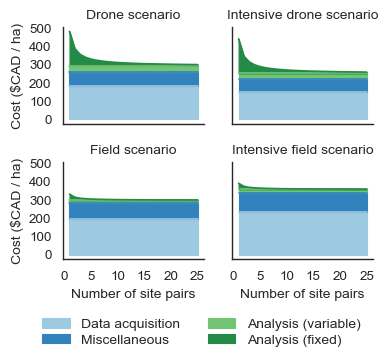

In [13]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

# Assuming df is your DataFrame and it's already imported

font_size = 10

def plot_stack(df, approach, title, ax):
    cmap = {'Data acquisition':'#9ecae1',
            'Miscellaneous':'#3182bd',
            'Analysis':'#74c476',
            'Analysis_fixed':'#238b45'}

    df = df.loc[(df['hectares']<=1000)&
                        (df['changes']=='1.0_1_1')&
                        (df['approach']==approach)]

    df.set_index('no_pairs', inplace=True)
    df = df.loc[:,['Data acquisition', 'Miscellaneous', 'Analysis', 'Analysis_fixed']]

    plot = df.plot.area(stacked=True, ax=ax, legend=False, color=[cmap[key] for key in df.columns])
    plot.set_title(title, fontsize=font_size)
    return plot

# Set Style and context
plt.style.use('default')
sns.set_style('white')
sns.set_context("paper", font_scale=1.1)

# Set up canvas with matplotlib pyplot
fig, axs = plt.subplots(2,2, figsize=(4,4), sharex=True, sharey=True)

subplots = ['RPAS - Basic', 'RPAS - Advanced', 'Field - 20', 'Field - 24']
titles = ['Drone scenario', 'Intensive drone scenario', 'Field scenario', 'Intensive field scenario']
df_copy = df.copy()

# Use flatten to simplify the iteration over the 2D array of axes
for ax, subplot, title in zip(axs.flatten(), subplots, titles):
    plot_stack(df_copy, subplot, title, ax=ax)

# Custom x-ticks and labels
for ax in axs.flatten():
    ax.set_yticks([0, 100, 200, 300, 400, 500])
    ax.set_yticklabels(['0', '100', '200', '300', '400', '500'])
    ax.set_xticks([0, 5, 10, 15, 20, 25])
    ax.set_xticklabels(['0', '5', '10', '15', '20', '25'])

# Set labels for the left-most and bottom axes only
axs[0, 0].set_ylabel('Cost ($CAD / ha)', fontsize=font_size)
axs[1, 0].set_ylabel('Cost ($CAD / ha)', fontsize=font_size)
axs[1, 0].set_xlabel('Number of site pairs', fontsize=font_size)
axs[1, 1].set_xlabel('Number of site pairs', fontsize=font_size)

# Manually create a legend with custom handles
handles = [mpatches.Patch(color='#9ecae1', label='Data acquisition'),
           mpatches.Patch(color='#3182bd', label='Miscellaneous'),
           mpatches.Patch(color='#74c476', label='Analysis'),
           mpatches.Patch(color='#238b45', label='Analysis - Fixed')]
fig.legend(handles, ['Data acquisition', 'Miscellaneous', 'Analysis (variable)', 'Analysis (fixed)'], loc='lower center', 
           ncol=2, labelspacing=0.2, fontsize=font_size, frameon=False, bbox_to_anchor=(0.47, 0.05))

# Adjust layout manually to make space for the legend and control spacing between plots
plt.subplots_adjust(bottom=0.2, wspace=0.2, hspace=0.4)

# Adjust layout for the legend
plt.subplots_adjust(bottom=0.3)

# Remove some plot boundary lines
sns.despine(top=True, right=True)

plt.show()
# fig.savefig("Figures/Cost_Distribution.tif", dpi=1200, bbox_inches='tight')


### Plot 4: Create data and plots for Uncertainty analysis

In [16]:
df2 = pd.DataFrame(columns=['no_pairs','no_transects','approach',
                           'Data acquisition', 'Analysis', 'Analysis_fixed', 'Miscellaneous', 'changes'])

row = 0
for appr in ['Field', 'RPAS - Basic', 'RPAS - Advanced']:
    for pairs in range(1,101):
        for change in [(0.9, 0.8), (1.0, 1.0), (1.1, 1.2)]:
            if appr=='Field':
                for trans in [12,16,20,24]:
                    outputs_1 = equations(pairs, trans, appr, acquisition_change=change[0], analys_change=change[1], miscel_change=change[0])
                    outputs_2 = equations(pairs, trans, appr, acquisition_change=change[0], analys_change=change[1], miscel_change=change[0])
                    outputs_3 = equations(pairs, trans, appr, acquisition_change=change[0], analys_change=change[1], miscel_change=change[0])

                    df2.loc[row] = [pairs] + [trans] + [appr+' - '+str(trans)] + [outputs_1[0]] + [outputs_1[1]] + [outputs_1[2]] + [outputs_1[3]] + [outputs_1[4]]
                    row += 1
                    df2.loc[row] = [pairs] + [trans] + [appr+' - '+str(trans)] + [outputs_2[0]] + [outputs_2[1]] + [outputs_2[2]] + [outputs_2[3]] + [outputs_2[4]]
                    row += 1
                    df2.loc[row] = [pairs] + [trans] + [appr+' - '+str(trans)] + [outputs_3[0]] + [outputs_3[1]] + [outputs_3[2]] + [outputs_3[3]] + [outputs_3[4]]
                    row += 1

            else:
                trans = 12
                outputs_1 = equations(pairs, trans, appr, acquisition_change=change[0], analys_change=change[1], miscel_change=change[0])
                outputs_2 = equations(pairs, trans, appr, acquisition_change=change[0], analys_change=change[1], miscel_change=change[0])
                outputs_3 = equations(pairs, trans, appr, acquisition_change=change[0], analys_change=change[1], miscel_change=change[0])

                df2.loc[row] = [pairs] + [trans] + [appr] + [outputs_1[0]] + [outputs_1[1]] + [outputs_1[2]] + [outputs_1[3]] + [outputs_1[4]]
                row += 1
                df2.loc[row] = [pairs] + [trans] + [appr] + [outputs_2[0]] + [outputs_2[1]] + [outputs_2[2]] + [outputs_2[3]] + [outputs_2[4]]
                row += 1
                df2.loc[row] = [pairs] + [trans] + [appr] + [outputs_3[0]] + [outputs_3[1]] + [outputs_3[2]] + [outputs_3[3]] + [outputs_3[4]]
                row += 1

df2['hectares'] = df2['no_pairs'] * 40

df2['Data acquisition'] = df2['Data acquisition'] / df2['hectares']
df2['Analysis'] = df2['Analysis'] / df2['hectares']
df2['Analysis_fixed'] = df2['Analysis_fixed'] / df2['hectares']
df2['Miscellaneous'] = df2['Miscellaneous'] / df2['hectares']

df2['cost_by_ha'] = df2['Data acquisition'] + df2['Analysis'] + df2['Analysis_fixed'] + df2['Miscellaneous']

df2.drop_duplicates(inplace=True)
df2.reset_index(drop=True, inplace=True)
df2.head()

,no_pairs,no_transects,approach,Data acquisition,Analysis,Analysis_fixed,Miscellaneous,changes,hectares,cost_by_ha
0,1,12,Field - 12,103.949999,8.2500,26.4,47.57625,0.9_0.8_0.9,40,186.176249
1,1,16,Field - 16,138.599999,11.0000,26.4,63.43500,0.9_0.8_0.9,40,239.434999
2,1,20,Field - 20,173.249999,13.7500,26.4,79.29375,0.9_0.8_0.9,40,292.693749
3,1,24,Field - 24,207.899998,16.5000,26.4,95.15250,0.9_0.8_0.9,40,345.952498
4,1,12,Field - 12,115.499999,10.3125,33.0,52.86250,1.0_1.0_1.0,40,211.674999


In [17]:
### Find intersections for curved lines

# Pivot table
piv_df = df2.pivot(index=['no_pairs','changes'], columns='approach', values='cost_by_ha').reset_index()

# Run function to get intersect points
intersects2 = []
for change in piv_df['changes'].unique():
    piv_df_copy = piv_df.loc[piv_df['changes']==change]
    for i in [i for i in piv_df.columns if 'RPAS' in i]:
        for j in [i for i in piv_df.columns if 'Field' in i]:
            intersects2.append((i, j, change, get_intersects(piv_df_copy, 'no_pairs', i, j)))

# List do DataFrame
intersects2 = pd.DataFrame(intersects2, columns=['RPAS', 'Field', 'Change', 'Break-even point'])

# Remove rows with "None" values from DataFrame
intersects2 = intersects2.loc[~intersects2['Break-even point'].isna()]

# Splitting the values in the 'Break-even point' column into 'x' and 'y'
intersects2[['x', 'y']] = intersects2['Break-even point'].apply(lambda x: pd.Series(str(x).strip('()').split(', ')))

# Convert the new columns to numeric values
intersects2[['x', 'y']] = intersects2[['x', 'y']].apply(pd.to_numeric)

# Check
intersects2.head()

,RPAS,Field,Change,Break-even point,x,y
2,RPAS - Advanced,Field - 20,0.9_0.8_0.9,"(2.8600000000000017, 276.51699999999994)",2.86,276.517000
3,RPAS - Advanced,Field - 24,0.9_0.8_0.9,"(1.4400000000000004, 340.77899999999994)",1.44,340.779000
6,RPAS - Basic,Field - 20,0.9_0.8_0.9,"(15.840000000000014, 268.96045000000004)",15.84,268.960450
7,RPAS - Basic,Field - 24,0.9_0.8_0.9,"(2.080000000000001, 333.24775000000005)",2.08,333.247750
10,RPAS - Advanced,Field - 20,1.0_1.0_1.0,"(3.330000000000002, 308.78187499999996)",3.33,308.781875


In [18]:
def plot_lines_and_fill(df, scenario1, scenario2, color1, color2, intersects, ax):
    from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
    
    ### - Do the main plotting
    X = df.loc[(df['changes']=='1.0_1.0_1.0')&(df['approach']==scenario1), 'no_pairs'].sort_values(ascending=True)
    Y1 = df.loc[(df['changes']=='0.9_0.8_0.9')&(df['approach']==scenario1), 'cost_by_ha'].sort_values(ascending=False)
    Y2 = df.loc[(df['changes']=='1.0_1.0_1.0')&(df['approach']==scenario1), 'cost_by_ha'].sort_values(ascending=False)
    Y3 = df.loc[(df['changes']=='1.1_1.2_1.1')&(df['approach']==scenario1), 'cost_by_ha'].sort_values(ascending=False)

    Y4 = df.loc[(df['changes']=='0.9_0.8_0.9')&(df['approach']==scenario2), 'cost_by_ha'].sort_values(ascending=False)
    Y5 = df.loc[(df['changes']=='1.0_1.0_1.0')&(df['approach']==scenario2), 'cost_by_ha'].sort_values(ascending=False)
    Y6 = df.loc[(df['changes']=='1.1_1.2_1.1')&(df['approach']==scenario2), 'cost_by_ha'].sort_values(ascending=False)

    ax.plot(X, Y1, lw=.01, color=color1, alpha=.01) # First set of lines
    ax.plot(X, Y2, lw=2, color=color1, linestyle='-')
    ax.plot(X, Y3, lw=.01, color=color1, alpha=.01)

    ax.plot(X, Y4, lw=.01, color=color2, alpha=.01) # Second set of lines
    ax.plot(X, Y5, lw=2, color=color2, linestyle='-')
    ax.plot(X, Y6, lw=.01, color=color2, alpha=.01)

    ax.fill_between(X, Y1, Y3, color=color1, alpha=.4) # Fill
    ax.fill_between(X, Y4, Y6, color=color2, alpha=.4)
    
    ### - Add the intersection points
    is_comb = [
        intersects.loc[(intersects['Change']=='1.0_1.0_1.0')&(intersects['RPAS']==scenario1)&(intersects['Field']==scenario2), ['x','y']].values[0].tolist(),
        intersects.loc[(intersects['Change']=='0.9_0.8_0.9')&(intersects['RPAS']==scenario1)&(intersects['Field']==scenario2), ['x','y']].values[0].tolist(),
        intersects.loc[(intersects['Change']=='1.1_1.2_1.1')&(intersects['RPAS']==scenario1)&(intersects['Field']==scenario2), ['x','y']].values[0].tolist()
    ]

    for i, (x, y) in enumerate(is_comb):
        if i == 0:
            fill_break_even = 'black'
            scatter_size = 32.5  # Larger size for black points
            # Draw Vertical lines
            ax.plot([x, x], [ax.get_ylim()[0], y], linestyle='--', color='gray')
            # Draw horizontal lines
            ax.plot([0, x], [y, y], linestyle='--', color='gray')
        else:
            fill_break_even = 'black'
            scatter_size = 15  # Smaller size for gray points
        
        ax.scatter(x, y, s=scatter_size, facecolors=fill_break_even, alpha=0.5, edgecolors='black', zorder=10)
    
    # Remove some plot boundary lines
    sns.despine(top=True, right=True)       
    
    # Set the margin to 0 on the x axis
    ax.margins(x=0)
  
    return ax


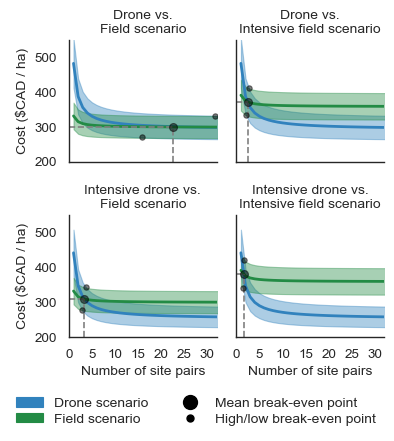

In [19]:
# ----------------------------------------------------
# Set plot settings

import matplotlib.lines as mlines
import matplotlib.patches as mpatches

# Set Style and context
plt.style.use('default')
sns.set_style('white')
sns.set_context("paper", font_scale=1.1)
font_size = 10

# Set up canvas with matplotlib pyplot
fig, axs = plt.subplots(2,2, figsize=(4,4), sharex=True, sharey=True)

# # Set labels and limits
plt.ylim(200, 550)
plt.xlim(0, 32)

# Modify data
df2_copy = df2.loc[df2['hectares']<=2000] # Keep only rows with hectares up to 2000

# ----------------------------------------------------
# Plot main line
axs[0,0] = plot_lines_and_fill(df=df2_copy, scenario1='RPAS - Basic', scenario2='Field - 20', 
                        color1='#3182bd', color2='#238b45', ax=axs[0,0],
                        intersects=intersects2)
axs[0,0].set_title("Drone vs.\nField scenario", y=0.99, fontsize=font_size)

axs[0,1] = plot_lines_and_fill(df=df2_copy, scenario1='RPAS - Basic', scenario2='Field - 24', 
                        color1='#3182bd', color2='#238b45', ax=axs[0,1],
                        intersects=intersects2)
axs[0,1].set_title("Drone vs.\nIntensive field scenario", y=0.99, fontsize=font_size)

axs[1,0] = plot_lines_and_fill(df=df2_copy, scenario1='RPAS - Advanced', scenario2='Field - 20', 
                        color1='#3182bd', color2='#238b45', ax=axs[1,0],
                        intersects=intersects2)
axs[1,0].set_title("Intensive drone vs.\nField scenario", y=0.99, fontsize=font_size)

axs[1,1] = plot_lines_and_fill(df=df2_copy, scenario1='RPAS - Advanced', scenario2='Field - 24', 
                        color1='#3182bd', color2='#238b45', ax=axs[1,1],
                        intersects=intersects2)
axs[1,1].set_title("Intensive drone vs.\nIntensive field scenario", y=0.99, fontsize=font_size)

axs[0,0].set_ylabel('Cost ($CAD / ha)', fontsize=font_size)
axs[1,0].set_ylabel('Cost ($CAD / ha)', fontsize=font_size)

axs[1,0].set_xlabel('Number of site pairs', fontsize=font_size)
axs[1,1].set_xlabel('Number of site pairs', fontsize=font_size)

# Set custom x-ticks and labels for each subplot
for ax in axs.flat:
    ax.set_xticks([0, 5, 10, 15, 20, 25, 30])
    ax.set_xticklabels(['0', '5', '10', '15', '20', '25', '30'])
    ax.set_yticks([200, 300, 400, 500])
    ax.set_yticklabels(['200', '300', '400', '500'])

# Create custom legend handles
blue_square = mpatches.Patch(color='#3182bd', label='Drone scenario')
green_square = mpatches.Patch(color='#238b45', label='Field scenario')
large_black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                   markersize=10, label='Mean break-even point')
small_black_circle = mlines.Line2D([], [], color='black', marker='o', linestyle='None',
                                   markersize=5, label='High/low break-even point')

# Add the custom legend below the plots
plt.figlegend(handles=[blue_square, green_square, large_black_circle, small_black_circle],
              loc='lower center', ncol=2, labelspacing=0.2, prop={'size':font_size}, 
              bbox_to_anchor=(0.49, -0.11), frameon=False)

# Adjust layout to make space for the legend
plt.tight_layout()
plt.show()

# fig.savefig("Figures/Uncertainty_analysis.tif", dpi=1200,bbox_inches='tight')